In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Variables that are constant for all simulations

In [2]:
# Refractive indices first. All lengths[t(k)] in nanometres
nclad = 1.0
nsub = 1.0
neff = 0.0

cav_lam = 650

wave_lo = 500
wave_hi = 800

variable = [1.33, 1.34, 1.35, 1.36]

#### Scattering matrix code, with loop over variable of interest

In [3]:
plt.rcParams.update({
    'font.size': 25,
    'axes.edgecolor': 'black',
    'axes.facecolor': 'white',
    'axes.labelcolor': 'black',
    'figure.facecolor': 'white',
    'figure.edgecolor': 'black',
    'legend.labelcolor': 'black',
    'legend.facecolor': 'None',
    'savefig.transparent': False,
    'text.color': 'black',
    'xtick.color': 'black',
    'xtick.labelcolor': 'inherit',
    'ytick.color': 'black',
    'ytick.labelcolor': 'inherit', })

Processing value: 1.33
	 SiN ridge width: 81 nm
	 "Air" gap width: 122 nm
	 "Air" cavity width: 244 nm
	 Effective period: 203 nm, FF: 0.40
Processing value: 1.34
	 SiN ridge width: 81 nm
	 "Air" gap width: 121 nm
	 "Air" cavity width: 244 nm
	 Effective period: 203 nm, FF: 0.40
Processing value: 1.35
	 SiN ridge width: 81 nm
	 "Air" gap width: 120 nm
	 "Air" cavity width: 244 nm
	 Effective period: 202 nm, FF: 0.40
Processing value: 1.36
	 SiN ridge width: 81 nm
	 "Air" gap width: 119 nm
	 "Air" cavity width: 244 nm
	 Effective period: 201 nm, FF: 0.40


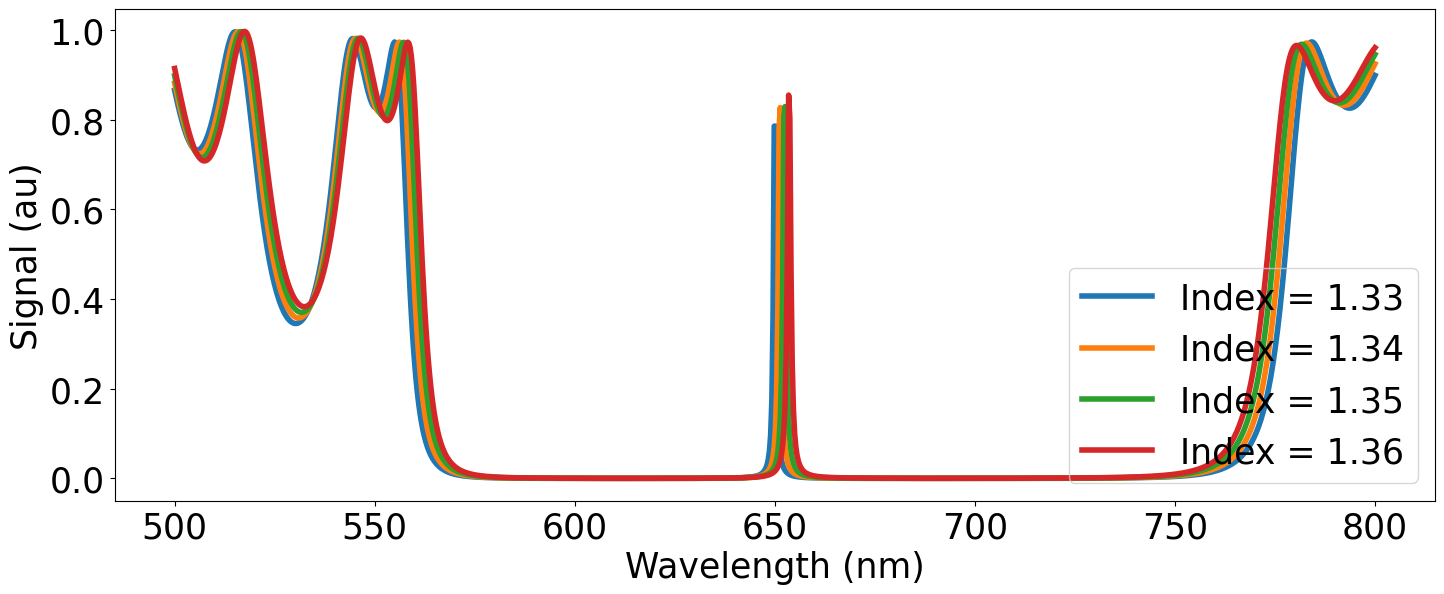

In [4]:
# Create a new subplot
num_plts = 1
fig, axes = plt.subplots(num_plts, 1, tight_layout=True, sharex=True, figsize=(15, 6.5))
# fig, axes = plt.subplots(num_plts, 1, sharex=True, figsize=(10, 2*num_plts))

lam_array = np.linspace(wave_lo, wave_hi, 1000, endpoint=True)

T = []
R = []
P = []

resonance_loc = []

for idx, val in enumerate(variable):
    print(f'Processing value: {val}')
    
    num_mirror_pairs = 15
    n_high = 2.0 #3.53
    t_high = cav_lam/(4 * n_high)

    n_low = val #3.11
    t_low = cav_lam/(4 * n_low)

    cavity_n = n_low
    cavity_t = (cav_lam / 2) / 1.33
    
    print(f'\t SiN ridge width: {t_high:.0f} nm')
    print(f'\t "Air" gap width: {t_low:.0f} nm')
    print(f'\t "Air" cavity width: {cavity_t:.0f} nm')
    print(f'\t Effective period: {t_high+t_low:.0f} nm, FF: {t_high/(t_high+t_low):.2f}')
    
    try:
        n.clear()
        t.clear()
    except NameError:
        pass
    
    n = [n_low, n_high] * num_mirror_pairs
    t = [t_low, t_high] * num_mirror_pairs

    n[num_mirror_pairs] = cavity_n
    t[num_mirror_pairs] = cavity_t

    T.clear()
    R.clear()
    P.clear()
    for lam in lam_array:
        k0 = (2 * np.pi) / lam
        M0 = [[1, 0],
              [0, 1]]

        for k in range(num_mirror_pairs * 2):
            ref_index = (n[k] * n[k]) - (neff * neff)
            nk = np.sqrt(ref_index) * k0
            nkt = nk * t[k]
            M = [[np.cos(nkt),          (1j / nk) * np.sin(nkt)],
                 [1j * nk * np.sin(nkt), np.cos(nkt)]]
            M0 = np.matmul(M0, M)

        kc = k0 * np.sqrt((nclad * nclad) - (neff * neff))
        ks = k0 * np.sqrt((nsub * nsub) - (neff * neff))

        trans = ((2 * ks) / ((ks * M0[0][0])
                             + (kc * M0[1][1])
                             + (ks * kc * M0[0][1])
                             + M0[1][0]))
        ref = ((ks * M0[0][0])
               - (kc * M0[1][1])
               + (ks * kc * M0[0][1])
               - (M0[1][0])) * (trans / (2 * ks))

        phase = np.arctan(trans.real / trans.imag)

        T.append(trans * trans.conjugate())
        R.append(ref * ref.conjugate())
        P.append(phase)

    y = [1 - r.real for r in R]
    resonance_loc.append(lam_array[np.argmax(y)])
    # Plot cosine using blue color with a continuous line of width 1 (pixels)
    colour = (0, 0, 1, 1)

    if num_plts == 1:
        a = axes
    else:
        a = axes[idx]

    a.plot(lam_array,
           y,
           linewidth=4,
           linestyle="-",
           label=f'Index = {val}')
# a.axvline(cav_lam, linewidth=1.5, color='r', alpha=0.2)
a.set_xlabel('Wavelength (nm)')
a.set_ylabel('Signal (au)')
# a.set_ylim([0, 6000])
# a.tick_params(axis='y', labelcolor=colour)
a.legend(loc='lower right')

# fig, ax = plt.subplots(1, 1, figsize=(10,5))
# ax.plot(variable, resonance_loc, marker='o')

fig.savefig('DBRIndexScan.png', format='png')